In [131]:
import sys
sys.path.append("../")

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *
from utils.utils import ring2nest

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

In [133]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Test embedding net

In [134]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [135]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.reorder(hp.ud_grade(hp_mask_nside1, nside), r2n=True)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

hp_mask_nside1 = hp.reorder(hp_mask_nside1, r2n=True)

In [136]:
hp_mask_nside1_ring = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0, mask_ring = True, inner = 0, outer = 25)
roi_sim_ring = hp.ud_grade(hp_mask_nside1_ring, 128)

In [137]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask = hp.reorder(hp_mask, r2n=True)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test data generation

In [224]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [225]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [226]:
from simulations.wrapper import simulator

In [227]:
import sys
from sbi import utils
from sbi import inference

In [228]:
from utils.templates import get_NFW2_template

In [229]:
# Load templates
temp_gce = np.load("../data/fermi_data/template_gce.npy")

fermi_exp_ring = np.load("../data/fermi_data/fermidata_exposure.npy")

# Rescaling factor to remove exposure from PS templates
rescale = fermi_exp_ring / np.mean(fermi_exp_ring)

roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp_ring, roi_normalize=roi_normalize_temps)

# NEST ordering
fermi_exp = hp.reorder(np.load("../data/fermi_data/fermidata_exposure.npy"), r2n=True)

temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk_thk = np.load("../data/fermi_data/template_dsk.npy")
temp_dsk = np.load("../data/external/template_disk_r_s_5_z_s_0.3.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

temp_mA_pibrem /= np.mean(temp_mA_pibrem[~roi_normalize_temps] )
temp_mA_ics /= np.mean(temp_mA_ics[~roi_normalize_temps] )


ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
# ps_mask = np.load("../data/fermi_data/fermidata_pscmask.npy") > 0

roi_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)

In [399]:
def get_signal_injection(coeff, plot_map=False, mask=hp_mask):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce), r2n=True)
    in_map[mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

def get_signal_injection_ps(coeff, plot_map=False, mask=hp_mask, ps="medium"):
    in_map = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
    in_map[mask] = 0
    
    if ps == "bright":
        sb1 = 20.
    elif ps == "medium":
        sb1 = 10.
    elif ps == "dim":
        sb1 = 5.
    
    if coeff != 0.:
        
        prior_ps = [[0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.], [0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.]]
        prior_ps = utils.BoxUniform(low=torch.tensor(prior_ps[0]), high=torch.tensor(prior_ps[1]))
        theta = prior_ps.sample((1,))[0]
        temps_ps_sim = [temp_gce]
        temps_poiss_sim = [temp_gce]
        
        ps_map = simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, hp.reorder(masks_list[0], n2r=True)
                      , hp.reorder(roi_mask_norm, n2r=True), hp.reorder(roi_mask, n2r=True), pc_inst.psf_r_func, fermi_exp)[0]
        
        ps_map = ring2nest(ps_map, roi_sim_ring)
    
    else:
        ps_map = np.zeros((~masks_list[0]).sum())
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)
    
    in_map = in_map[~masks_list[0]]
    in_map += ps_map[0]
    
    in_map = torch.Tensor(in_map)
    
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

def get_signal_injection_test(coeff, plot_map=False, mask=hp_mask, ps="medium"):
    in_map = np.zeros_like(hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True))
    in_map[mask] = 0
    
    if ps == "bright":
        sb1 = 20.
    elif ps == "medium":
        sb1 = 10.
    elif ps == "dim":
        sb1 = 5.
    
    if coeff != 0.:
        
        prior_ps = [[0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.], [0, coeff * 1., 20.0, 1.6, -5.0, sb1, 2.]]
        prior_ps = utils.BoxUniform(low=torch.tensor(prior_ps[0]), high=torch.tensor(prior_ps[1]))
        theta = prior_ps.sample((1,))[0]
        temps_ps_sim = [temp_gce]
        temps_poiss_sim = [temp_gce]
        
        ps_map = simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, hp.reorder(masks_list[0], n2r=True)
                      , hp.reorder(roi_mask_norm, n2r=True), hp.reorder(roi_mask, n2r=True), pc_inst.psf_r_func, fermi_exp)[0]
        
        ps_map = ring2nest(ps_map, roi_sim_ring)
    
    else:
        ps_map = np.zeros((~masks_list[0]).sum())
    
    if plot_map:
        hp.mollview(in_map, max=100, nest=True)
    
    in_map[~masks_list[0]] += ps_map[0]    
    
    return in_map

In [400]:
the_map = get_signal_injection_test(1., plot_map=False,)

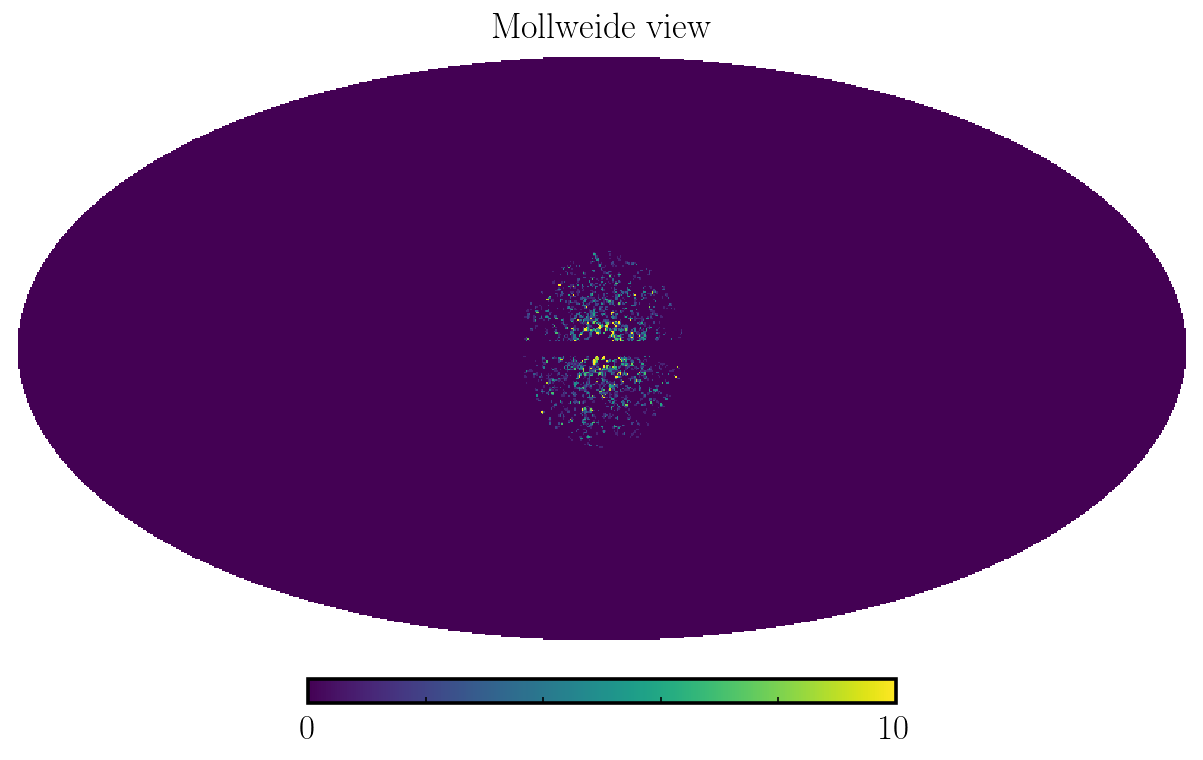

In [401]:
hp.mollview(the_map, max=10, nest=True)

In [402]:
temp_gce_nest = hp.reorder(temp_gce, r2n=True)
np.mean(the_map[~roi_mask_norm]) * np.sum(temp_gce_nest[~roi_mask_norm]) / np.sum(temp_gce_nest[~hp_mask])

1.0125159628662725

## SNPE


In [231]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, fc_dims=None).to(device)

In [232]:
sg_embed(get_signal_injection(0.).unsqueeze(0),).shape

torch.Size([1, 258])

In [233]:
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [234]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [235]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 0.001], [1.5, 1.5, 1.5, 12., 5.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2.5, 20.0, 1.99, 1.99, 40.0, 4.99, 2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.5] + prior_poiss[1] + prior_ps[1]))

In [236]:
from sbi import utils as utils

In [237]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [238]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [239]:
poiss_labels = [r"Iso", r"Bub", r"3FGL", r"$\pi^0$/brem", r"ICS"]
ps_labels = [r"GCE PS", r"Disk PS"]
temps_poiss = hp.reorder([temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics], r2n=True)
temps_ps = hp.reorder([temp_gce / rescale , temp_dsk / rescale ], r2n=True)

In [240]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [241]:
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25), r2n=True)

In [242]:
from sbi.utils import x_shape_from_simulation

In [243]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = '2b52bb386e3a42d691c9c9a8f3c5dfc4'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/12/' + run_id + '/artifacts/density_estimator')

In [244]:
from utils.plotting import make_plot, make_signal_injection_plot
roi_sim = masks_list[0]

### Analysis on simulations

In [223]:
n_samples = 20000

In [161]:
# data_map = torch.Tensor(ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:5, 0, :], roi_sim_ring))
# aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
# thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]
# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=15, custom_mask=ps_mask), r2n=True)

# indices_mask_reduced = np.intersect1d(np.where(~masks_list[0] == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

# a = indices_mask_reduced
# b = np.arange(np.sum(~masks_list[0] == 1))
# c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

# data_map[:, c] = 0.

# the_map = np.zeros(hp.nside2npix(128))
# the_map[~masks_list[0]] = data_map[0]

# hp.mollview(the_map, nest=True)

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 27.99622997 127.30010434 629.34100475]
[0.05729452 0.14362218 0.29002733]
[0.01091295 0.03785977 0.11820228]
Removed no burn in
$7.7^{+0.2}_{-0.6}$ & $10.6^{+3.3}_{-5.9}$ & $2.9^{+0.6}_{-1.3}$ & $6.2^{+0.5}_{-1.1}$ & $2.3^{+0.2}_{-0.5}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 22.11404014 124.82301705 694.94974936]
[0.03742775 0.10190267 0.24097141]
[0.00822491 0.03451389 0.12696247]
Removed no burn in
$7.6^{+0.2}_{-0.6}$ & $7.7^{+2.9}_{-4.6}$ & $2.2^{+0.6}_{-1.0}$ & $7.5^{+0.5}_{-1.3}$ & $1.1^{+0.1}_{-0.2}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 30.07073056 146.78006698 803.35389874]
[0.06447411 0.15242934 0.30618995]
[0.01144541 0.04121589 0.13721238]
Removed no burn in
$7.3^{+0.2}_{-0.6}$ & $11.9^{+3.4}_{-6.4}$ & $3.1^{+0.6}_{-1.6}$ & $4.9^{+0.5}_{-1.1}$ & $1.6^{+0.2}_{-0.5}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 23.88765212 119.90070883 613.67433202]
[0.0485091  0.12046957 0.24626201]
[0.00912347 0.03326903 0.1116744 ]
Removed no burn in
$7.1^{+0.2}_{-0.6}$ & $9.6^{+3.0}_{-5.4}$ & $3.0^{+0.7}_{-1.6}$ & $3.8^{+0.4}_{-0.9}$ & $2.6^{+0.3}_{-0.8}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[  54.04949224  268.94738847 1293.57951297]
[0.08912886 0.22473139 0.46554332]
[0.02018514 0.07680928 0.23759593]
Removed no burn in
$7.4^{+0.2}_{-0.6}$ & $17.4^{+5.7}_{-10.0}$ & $2.1^{+0.5}_{-0.9}$ & $6.5^{+0.5}_{-1.1}$ & $2.1^{+0.2}_{-0.4}$


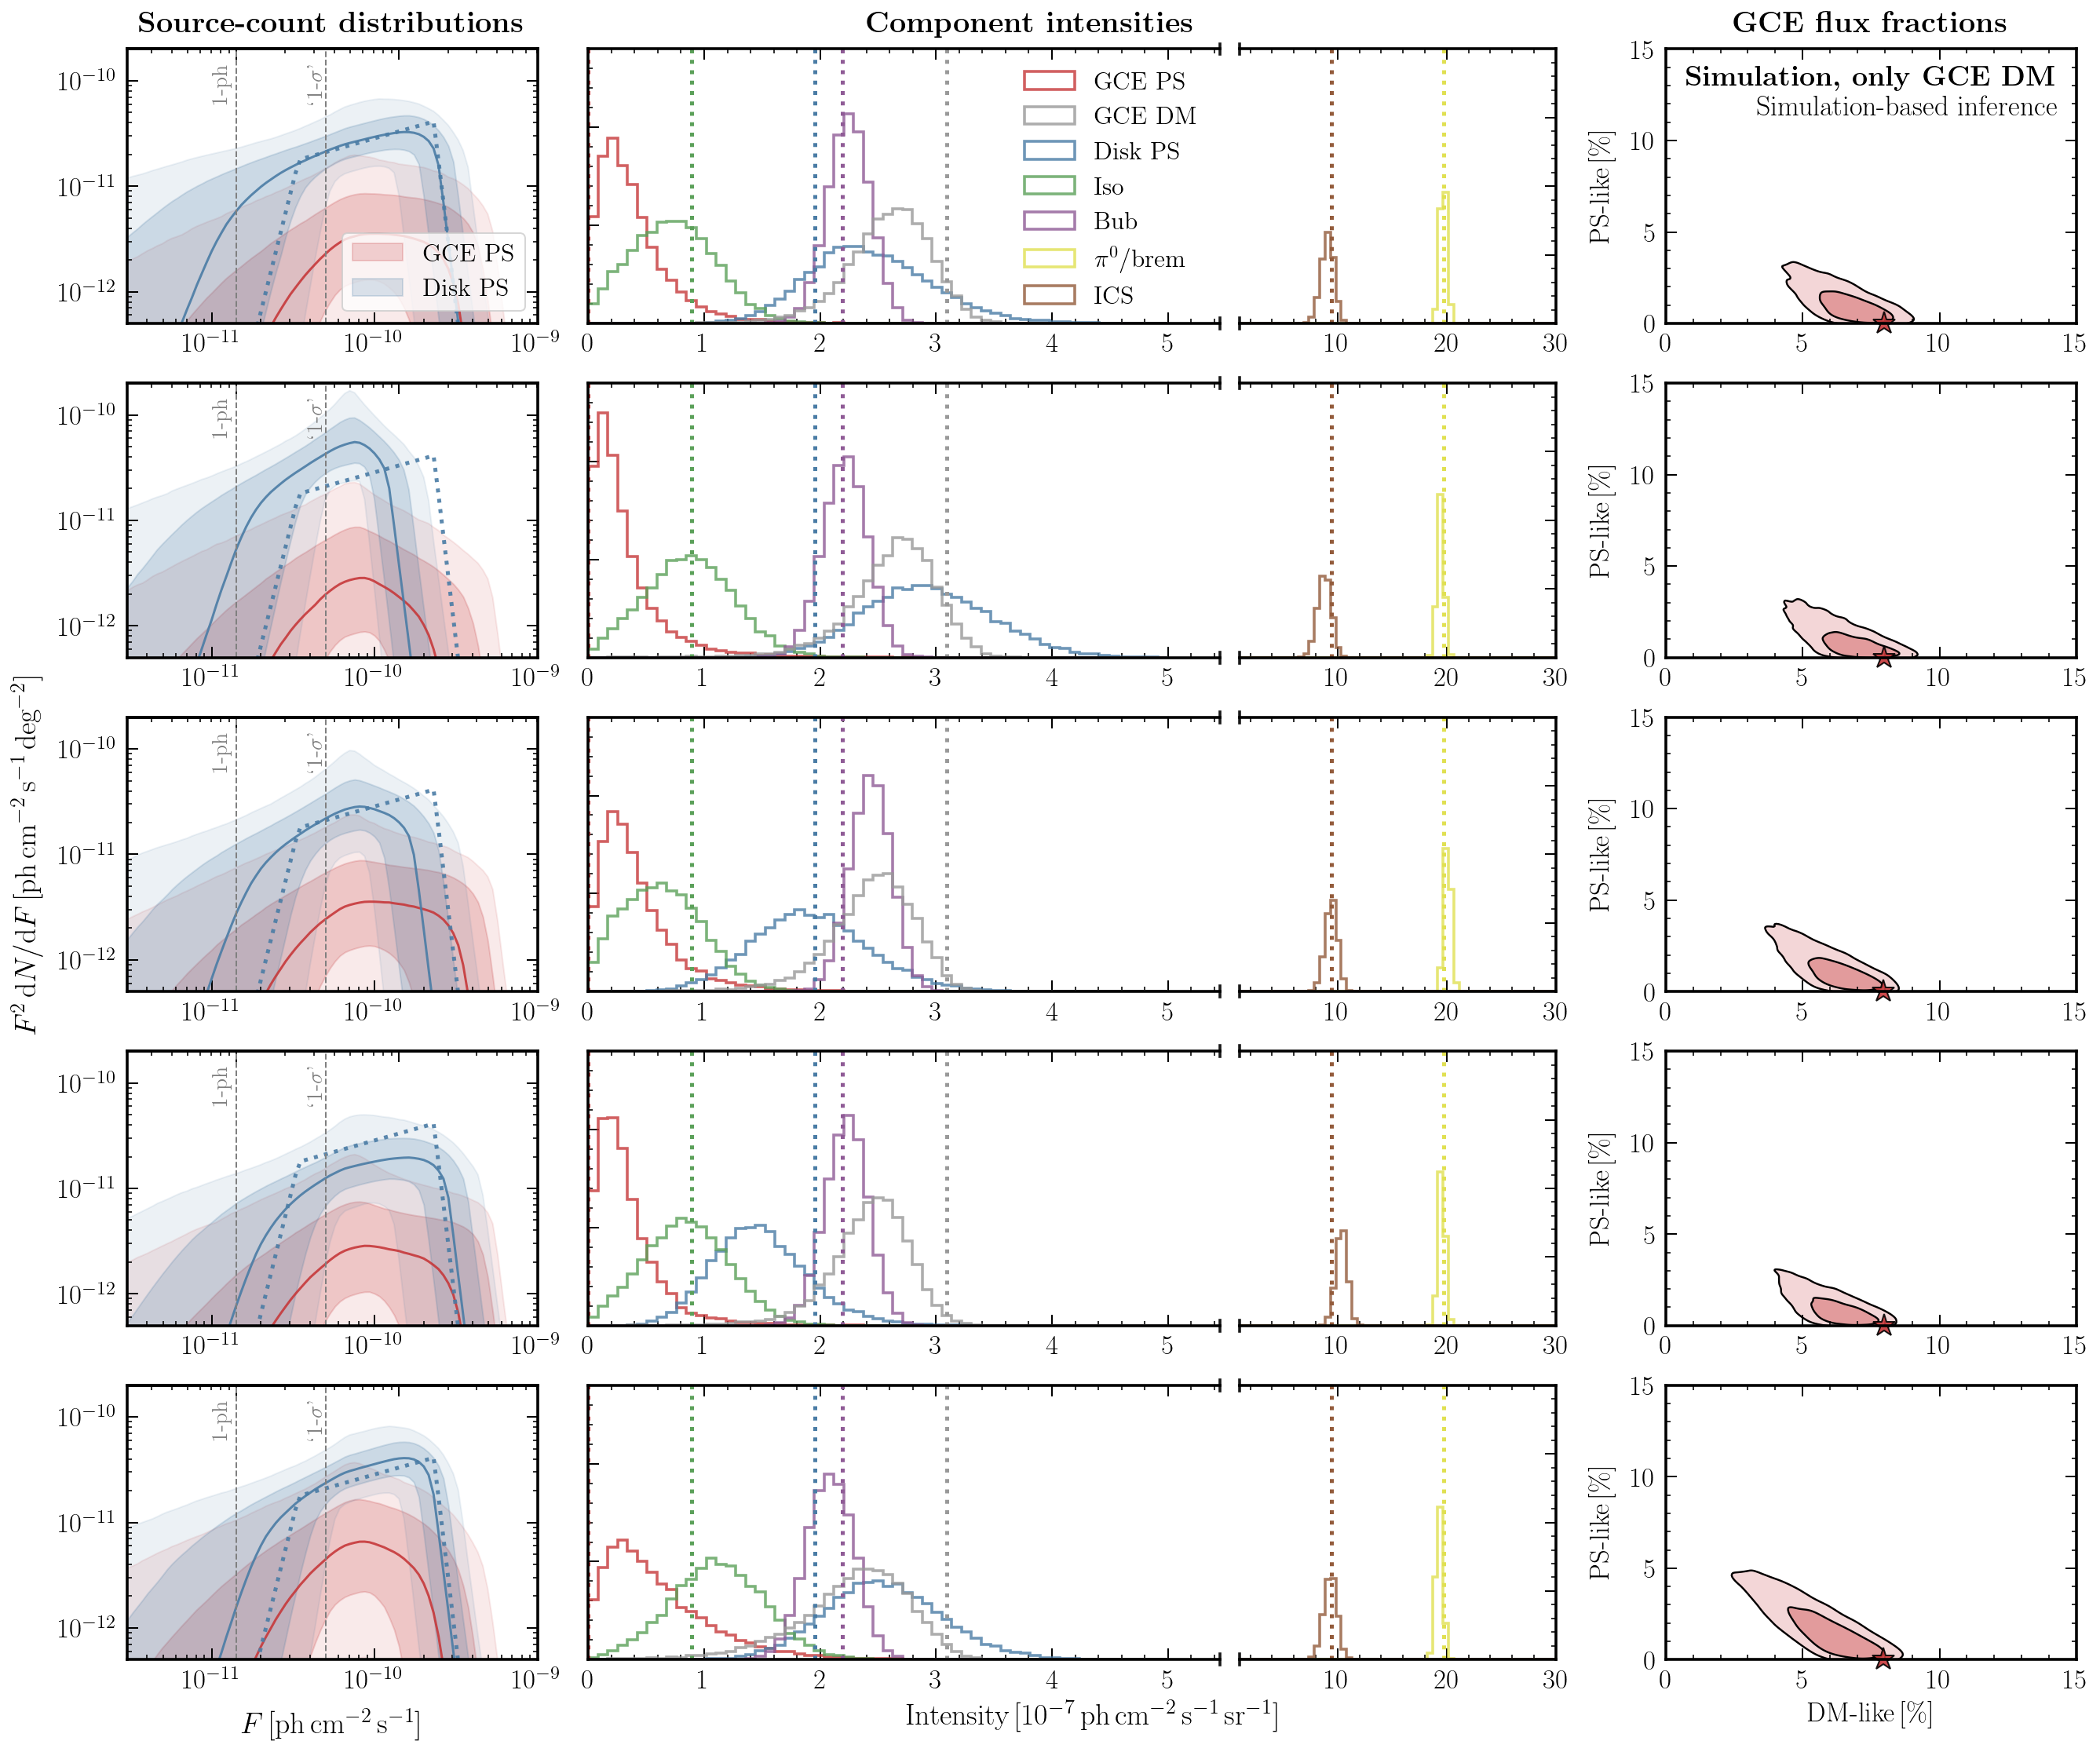

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [162]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 4 / 1.3 * 5), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_dm.pdf", sub1=r"\bf{Simulation, only GCE DM}", sub2=r"Simulation-based inference") 

Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 513.90468508  951.19725326 1701.20965603]
[1.23701346 1.3901816  1.53822198]
[0.25414098 0.40928872 0.58153369]
Removed no burn in
$8.7^{+0.3}_{-0.7}$ & $92.6^{+1.9}_{-6.1}$ & $1.6^{+0.1}_{-0.3}$ & $4.6^{+0.5}_{-1.2}$ & $2.0^{+0.3}_{-0.6}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 584.91336949 1286.17207882 2688.63209226]
[1.10089267 1.3228668  1.50404378]
[0.26514376 0.46700281 0.69329706]
Removed no burn in
$8.8^{+0.3}_{-0.7}$ & $86.9^{+3.6}_{-11.8}$ & $1.8^{+0.2}_{-0.4}$ & $5.7^{+0.5}_{-1.3}$ & $1.6^{+0.3}_{-0.6}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 554.91965857 1121.67144039 2098.89941321]
[1.18369986 1.34262139 1.49056437]
[0.26527048 0.44303349 0.63255207]
Removed no burn in
$8.5^{+0.3}_{-0.7}$ & $91.3^{+2.3}_{-7.7}$ & $1.7^{+0.2}_{-0.4}$ & $2.8^{+0.4}_{-0.9}$ & $3.5^{+0.5}_{-1.4}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 518.35029438 1141.51675044 2412.34165148]
[1.05981221 1.2822991  1.47109171]
[0.24096029 0.43178472 0.64416348]
Removed no burn in
$8.6^{+0.3}_{-0.7}$ & $85.7^{+3.7}_{-12.4}$ & $1.7^{+0.2}_{-0.4}$ & $5.7^{+0.5}_{-1.2}$ & $2.2^{+0.2}_{-0.5}$


Drawing 20000 posterior samples:   0%|          | 0/20000 [00:00<?, ?it/s]

[ 484.29896375 1166.5576753  2781.38369271]
[0.9832742  1.24013209 1.467824  ]
[0.21840732 0.41581252 0.66265923]
Removed no burn in
$9.0^{+0.3}_{-0.7}$ & $79.2^{+5.1}_{-14.5}$ & $1.9^{+0.2}_{-0.5}$ & $5.2^{+0.5}_{-1.1}$ & $2.3^{+0.2}_{-0.6}$


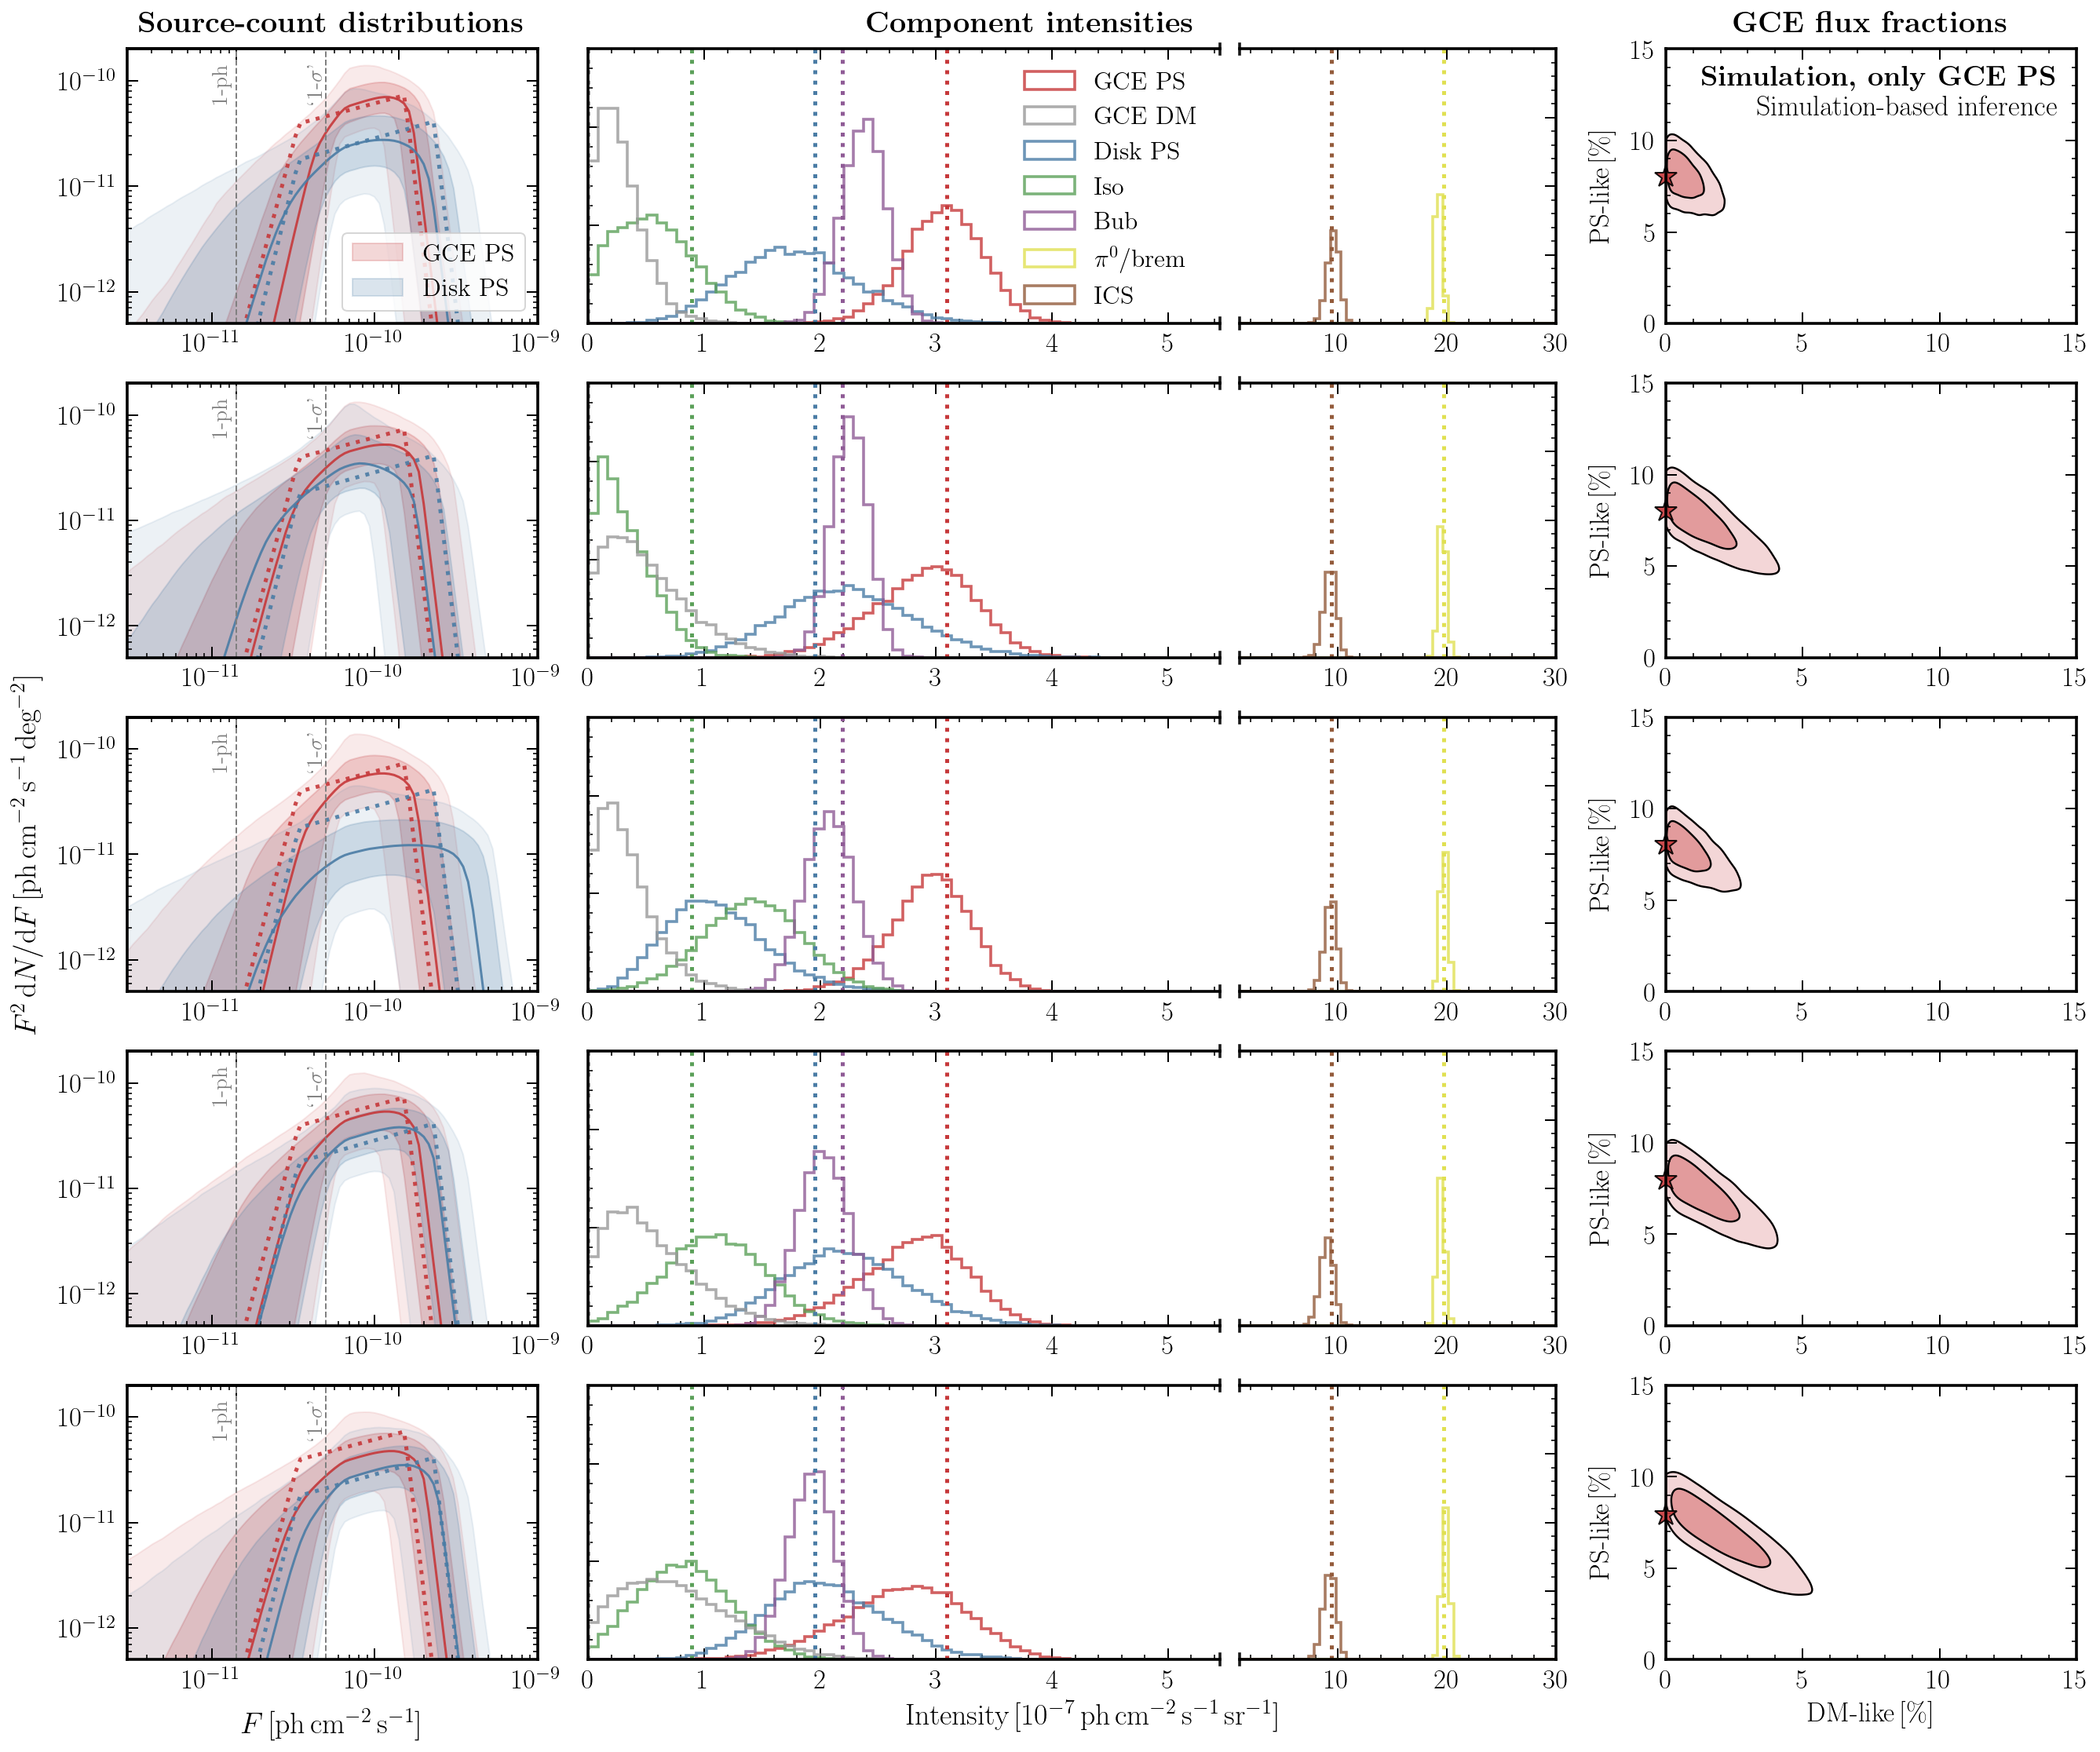

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [163]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only.npy")[:5, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_PS_only.npy")[:5]
thetas = np.load("../data/samples/theta_ModelO_PS_only.npy")[:5]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 4. / 1.3 * 5), n_samples=n_samples, \
          temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_ps.pdf", sub1=r"\bf{Simulation, only GCE PS}", sub2=r"Simulation-based inference") 

### Analysis on data

In [245]:
roi_mask_reduced = hp.reorder(cm.make_mask_total(nside=128, band_mask=True, band_mask_range=2, mask_ring=True, inner=0, 
                                                 outer=25, custom_mask=ps_mask), r2n=True)

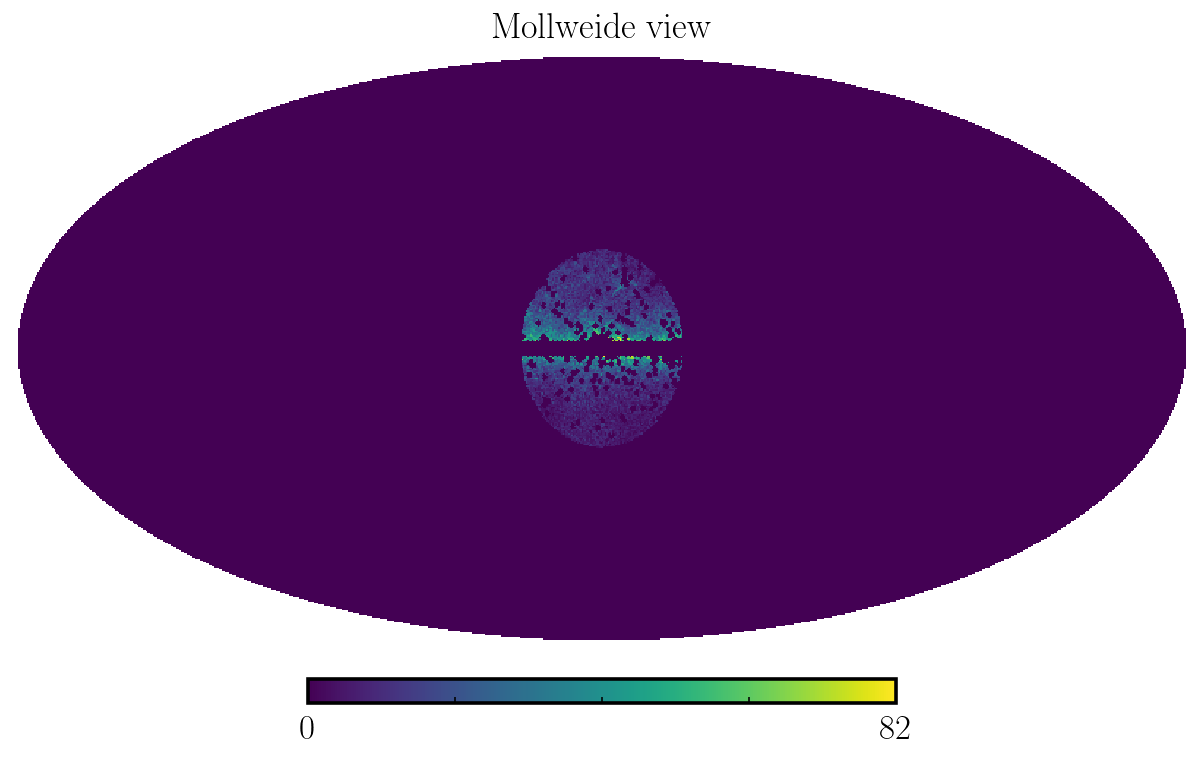

In [246]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection(coeff, mask=hp_mask).detach().numpy() for coeff in coeff_ary]))

data_map = x_test[:, 0, :-2]
aux = x_test[:, :, -2:]

indices_mask_reduced = np.intersect1d(np.where(~masks_list[0] == 1), np.where(~roi_mask_reduced == 1), return_indices=True)[1]

a = indices_mask_reduced
b = np.arange(np.sum(~masks_list[0] == 1))
c = torch.Tensor(np.setdiff1d(np.union1d(a, b), np.intersect1d(a, b))).type(torch.int64)

data_map[:, c] = 0.

the_map = np.zeros(hp.nside2npix(128))
the_map[~masks_list[0]] = data_map[0]

hp.mollview(the_map, nest=True)

In [247]:
n_samples = 50000

Drawing 50000 posterior samples:   0%|          | 0/50000 [00:00<?, ?it/s]

[ 208.02105866  899.31193959 3251.20444212]
[0.23067452 0.5187895  0.87756078]
[0.07660858 0.26380392 0.60095865]
5.070772692714483e-11 70054284171.79971
Removed no burn in
$7.8^{+0.2}_{-0.6}$ & $37.8^{+8.7}_{-19.3}$ & $1.3^{+0.3}_{-0.4}$ & $5.0^{+0.5}_{-1.1}$ & $2.2^{+0.2}_{-0.5}$


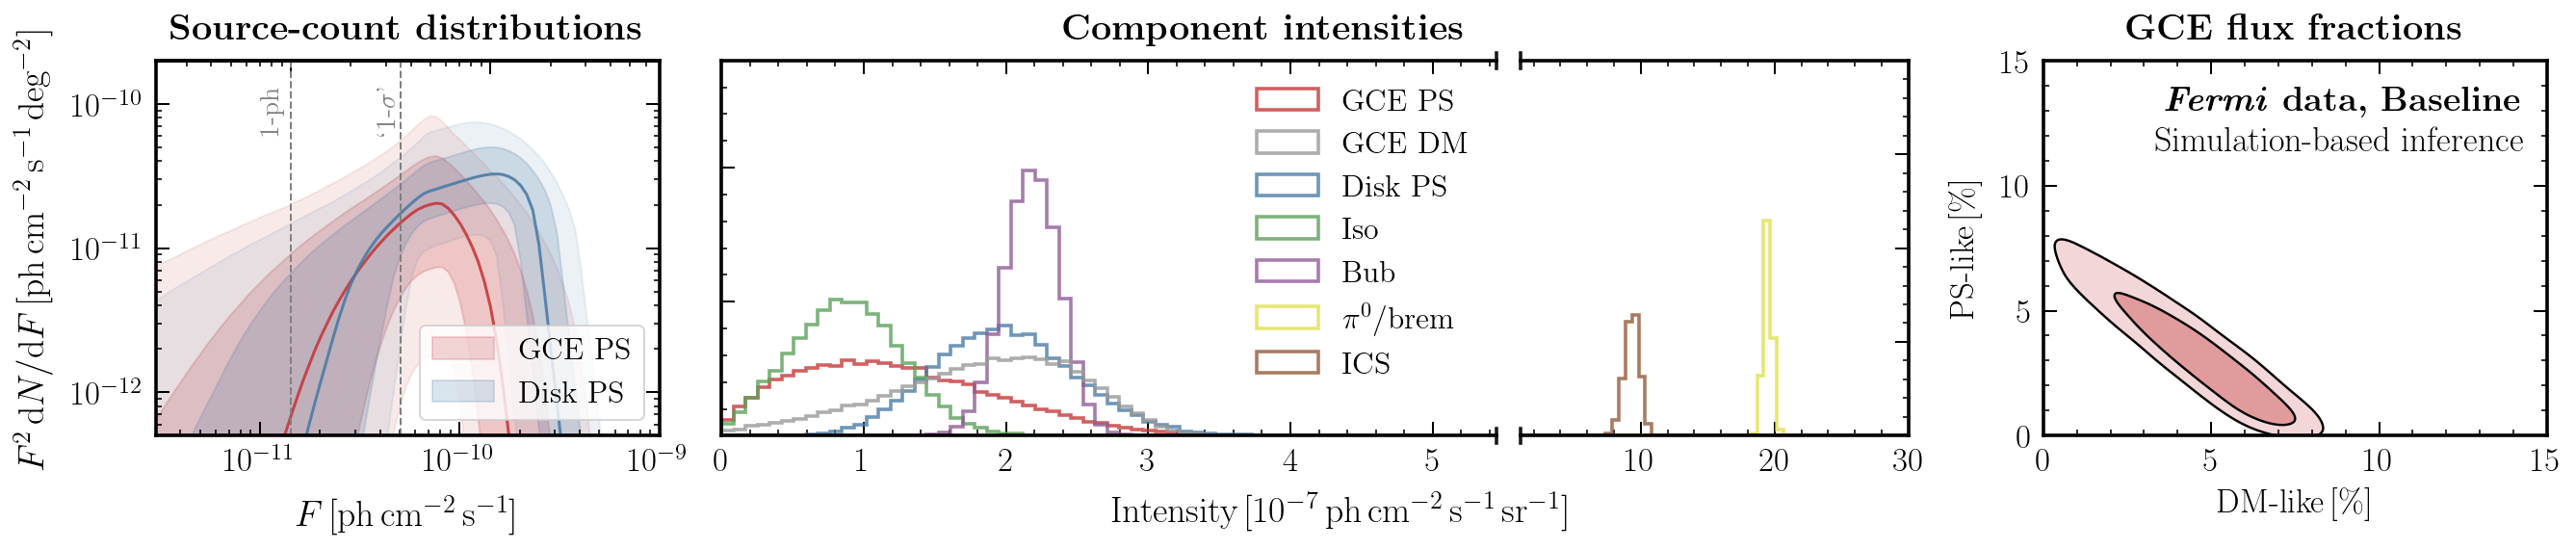

<Figure size 432x324 with 0 Axes>

In [248]:
x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)

posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, \
          signal_injection=True, figsize=(24 / 1.3, 5 / 1.3), save_filename="../paper/plots/data_fid_sbi.pdf", n_samples=n_samples, temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Baseline}", sub2=r"Simulation-based inference")

In [129]:
data_samples = posterior.sample(sample_shape=(10000,), x=x_test)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [130]:
np.save("../data/post_fid.npy", data_samples.detach().numpy())

In [84]:
np.percentile(data_samples.detach().numpy()[:, 10], [16,50,84])

array([ 6.29513956,  9.02238846, 15.28837009])

In [146]:
data_samples.mean(axis=0)

tensor([ 0.8594,  0.4042,  0.9076,  0.7456,  7.9115,  3.7623,  0.4852, 14.9713,
         1.5813, -3.6856, 12.4307,  2.3454,  0.8583, 14.9566,  1.5559, -4.2118,
        17.8425,  2.7101])

In [97]:
data_samples.mean(axis=0)

tensor([ 0.9286,  0.4314,  0.8864,  0.7524,  7.8482,  3.7519,  0.4267, 14.8363,
         1.5499, -3.5068, 12.0333,  2.3526,  0.9118, 15.0171,  1.5408, -4.5344,
        15.4356,  2.8705], grad_fn=<MeanBackward1>)

### Signal injection on data

In [184]:
n_samples = 10000

#### DM signal injection


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


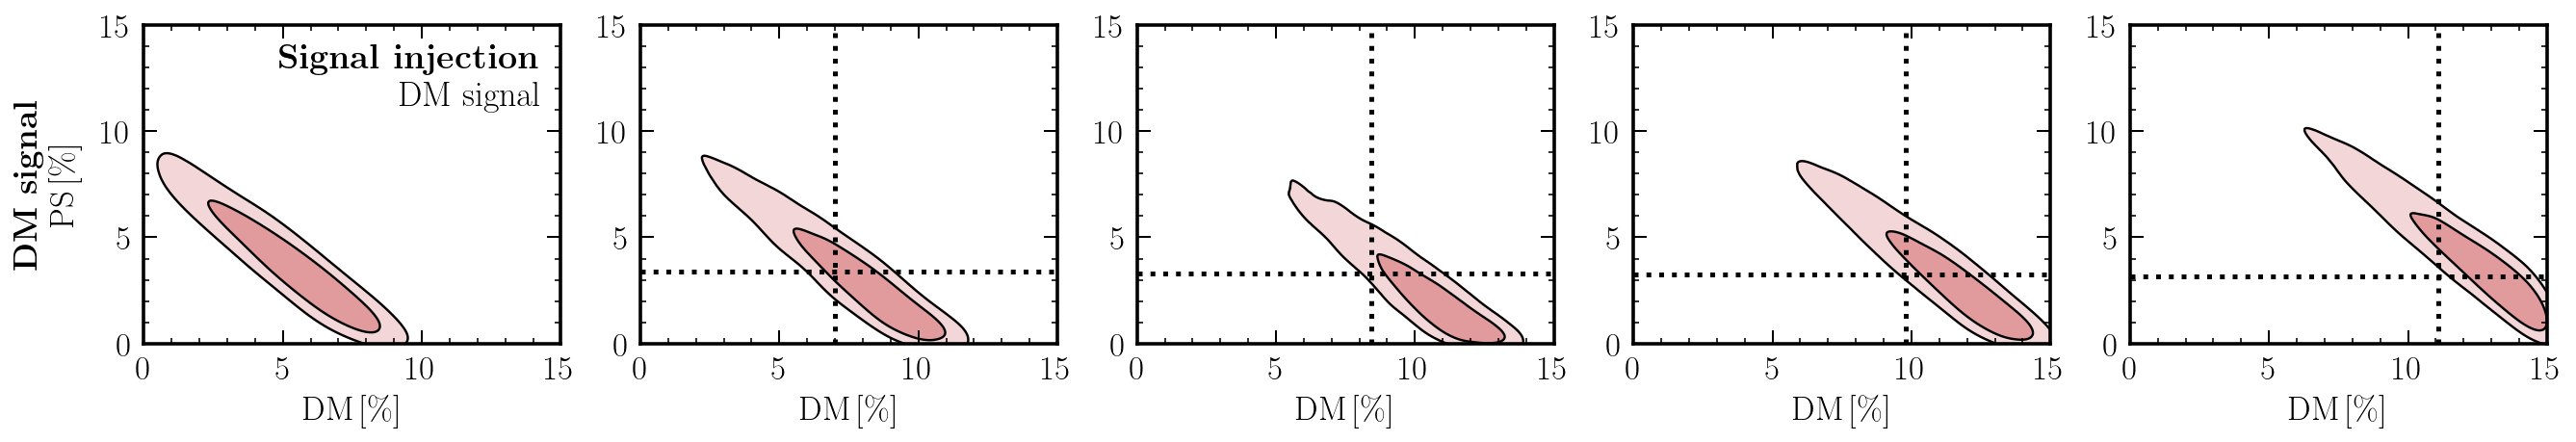

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [185]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)

make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="dm", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_dm.pdf", sub1=r"\bf{Signal injection}", sub2="DM signal")

#### PS signal injection

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


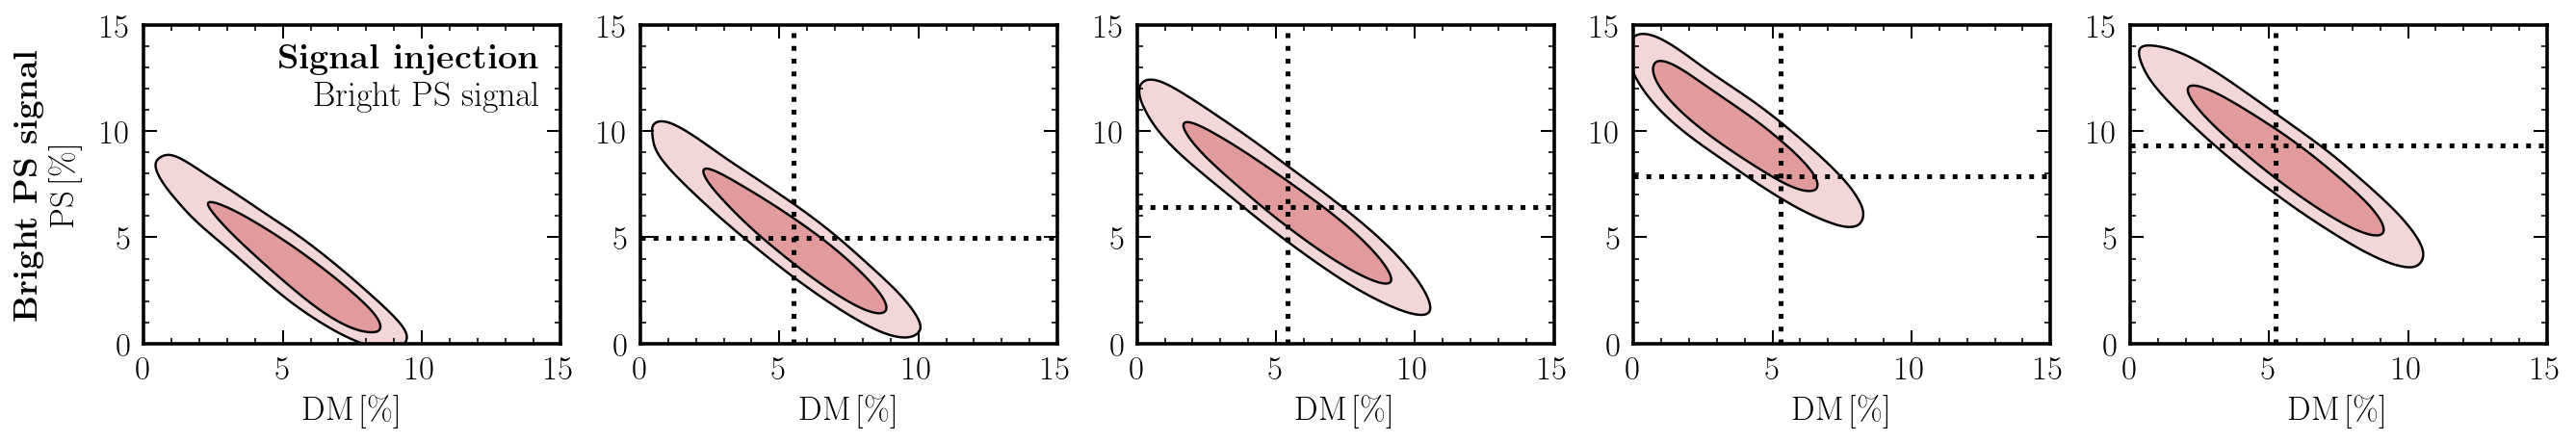

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [186]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='bright').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, \
                           signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Bright PS signal")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


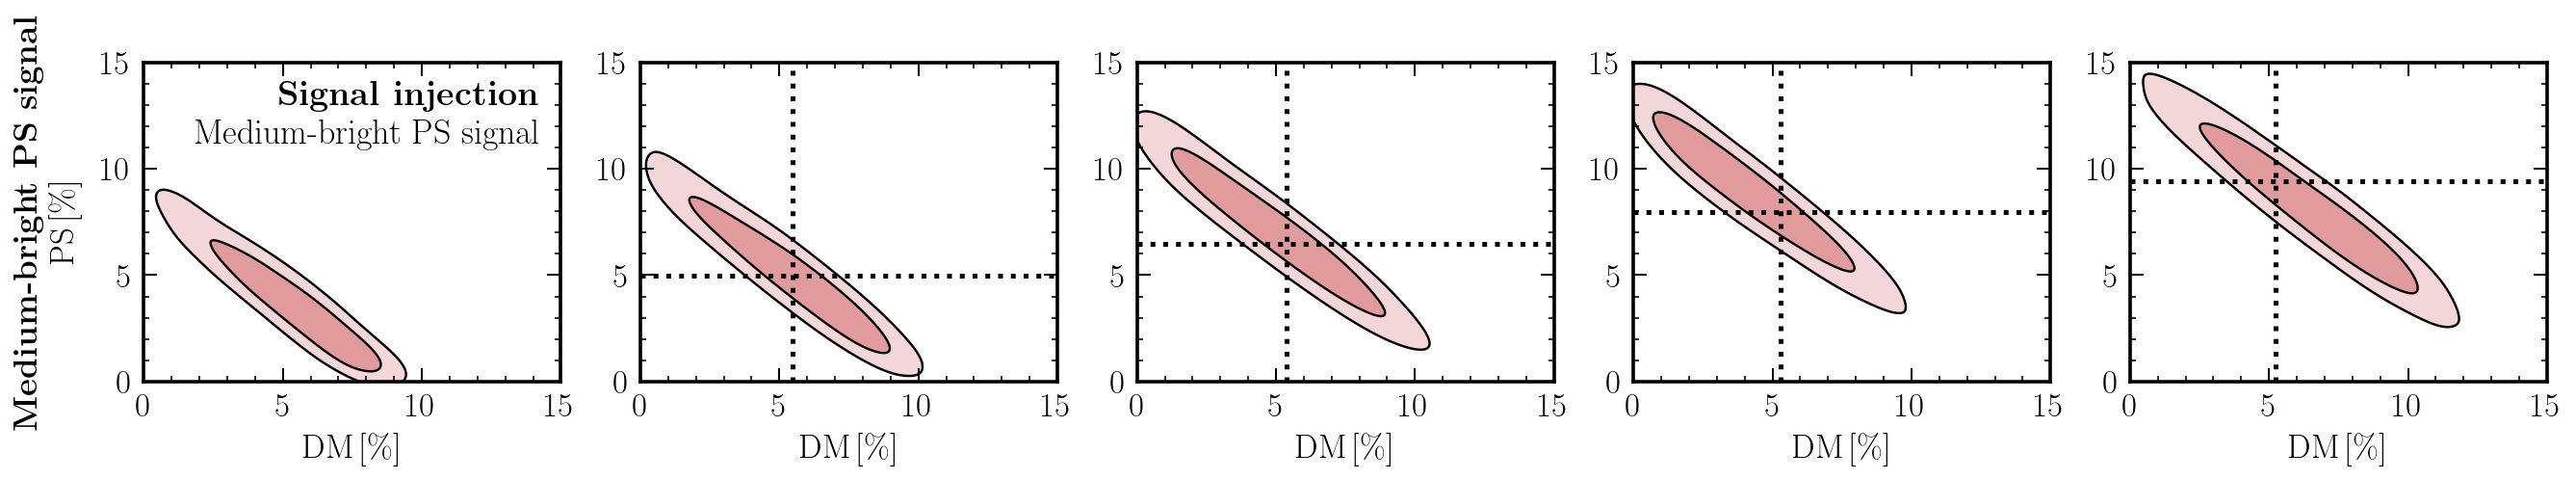

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [187]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='medium').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_med_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Medium-bright PS signal")

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


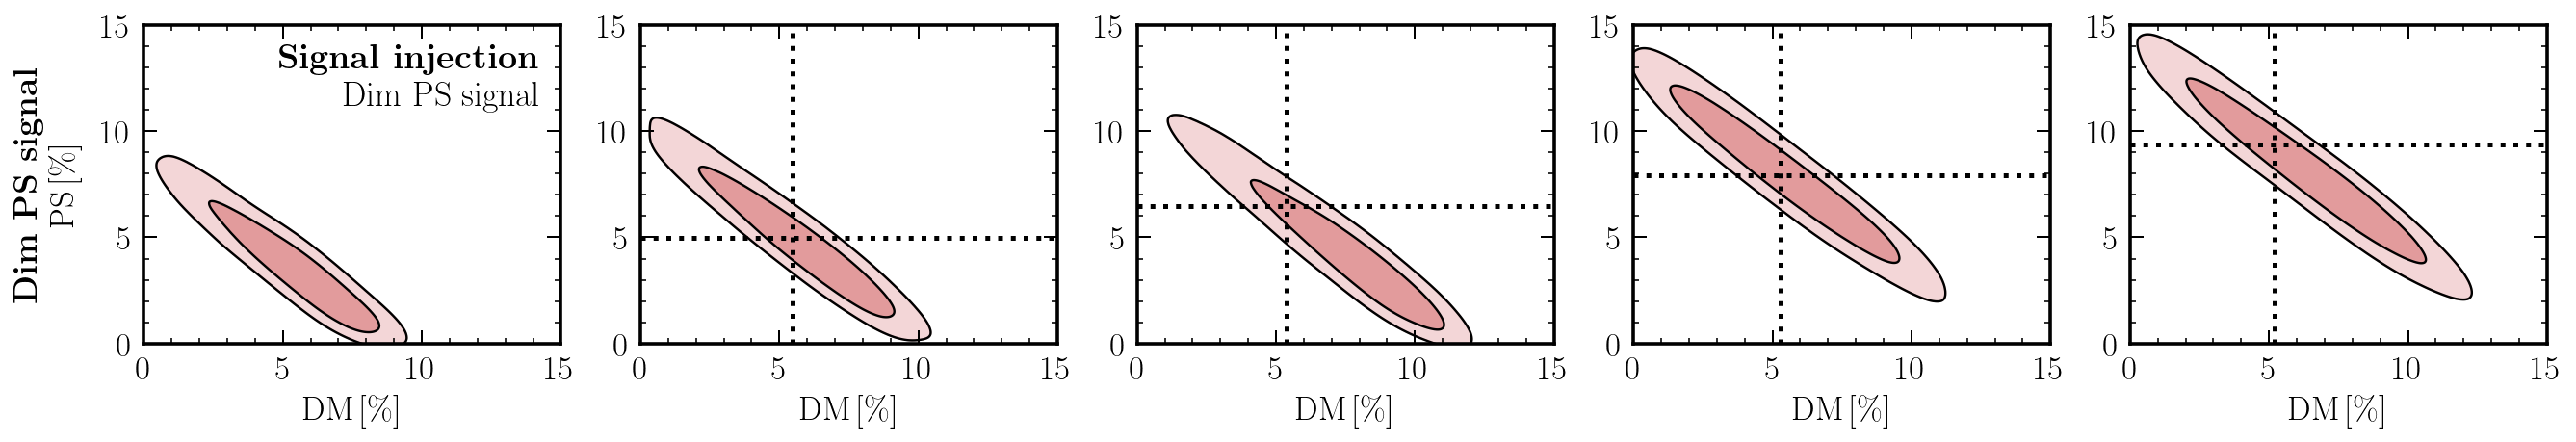

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [180]:
coeff_ary = np.linspace(0, 1., 5)
x_test = torch.Tensor(np.array([get_signal_injection_ps(coeff, ps='dim').detach().numpy() for coeff in tqdm_notebook(coeff_ary)]))

inference_inst.x_shape = x_shape_from_simulation(x_test)
posterior = inference_inst.build_posterior(prior, density_estimator)
make_signal_injection_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask, is_data=True, signal_injection="ps", n_samples=n_samples, coeff_ary=coeff_ary, temps_dict=temps_dict, figsize=(24 / 1.3, 4 / 1.3), save_filename="../paper/plots/data_sig_inj_dim_ps.pdf", sub1=r"\bf{Signal injection}", sub2="Dim PS signal")

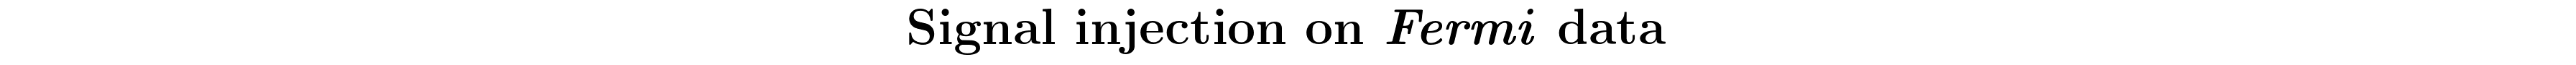

In [41]:
fig=plt.figure(figsize=(25,0.5))
ax=fig.add_subplot(1,1,1)
plt.text(0.5, 0.5,r'\bf{Signal injection on \emph{Fermi} data}',horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize=35)
plt.axis('off')
plt.tight_layout()
plt.savefig("../paper/plots/sig_inj_title.pdf")

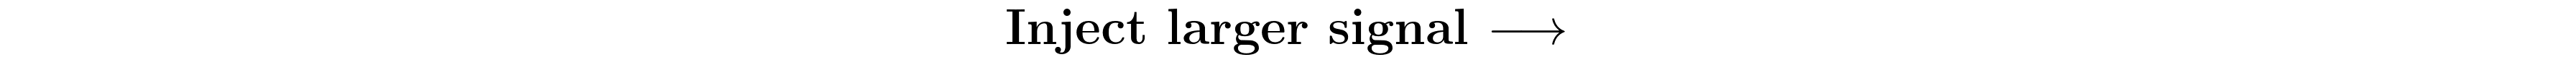

In [42]:
fig=plt.figure(figsize=(25,0.5))
ax=fig.add_subplot(1,1,1)
plt.text(0.5, 0.5,r'\bf{Inject larger signal $\longrightarrow$}',horizontalalignment='center',verticalalignment='center',transform = ax.transAxes, fontsize=35)
plt.axis('off')
plt.tight_layout()
plt.savefig("../paper/plots/sig_inj_chyron.pdf")

### NPTF analysis on data

[ 462.62266046 1573.3642634  3910.643931  ]
[0.38385615 0.73394111 1.10240841]
[0.16259308 0.45875525 0.83667716]
5.070772692714483e-11 12.618789194404245 70054284171.79971
Removed no burn in
$7.7^{+0.2}_{-0.6}$ & $55.0^{+8.8}_{-22.9}$ & $1.1^{+0.2}_{-0.2}$ & $5.4^{+0.5}_{-1.1}$ & $2.0^{+0.2}_{-0.5}$


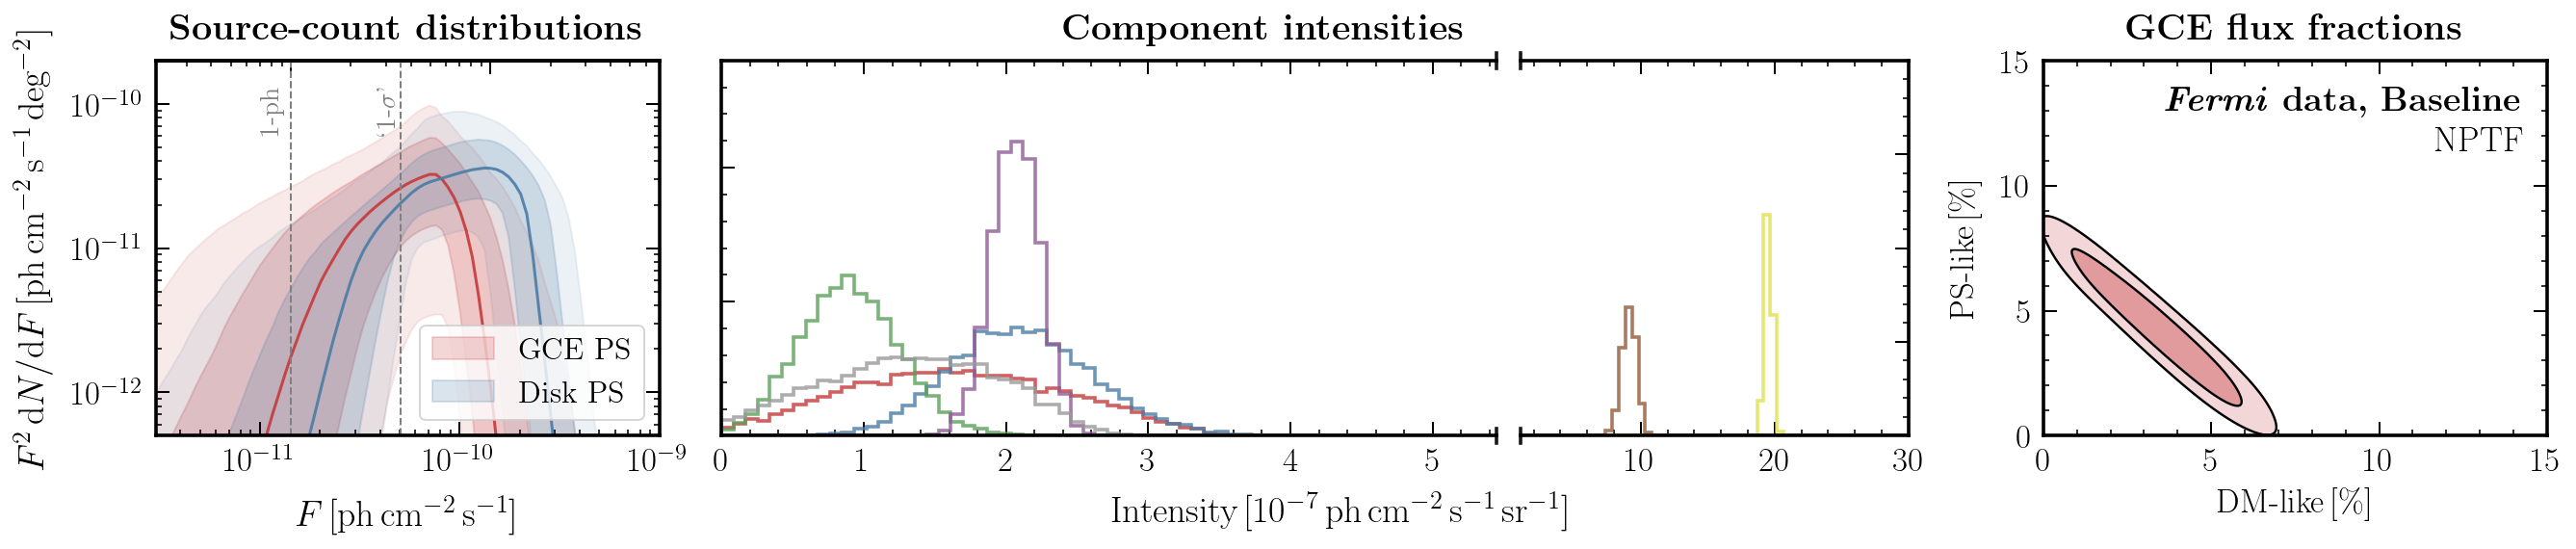

<Figure size 432x324 with 0 Axes>

In [289]:
coeff_ary = [0.]

samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/fermi_data_thin_disk_1000_-1_samples.npz")["samples_weighted"])
samples_weighted = torch.unsqueeze(samples_weighted, 0).detach().numpy()

fermi_data = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy()[:,:-2] for coeff in coeff_ary]))

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=None, roi_sim=roi_sim, \
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=False, figsize=(24 / 1.3, 5 / 1.3), nptf=True, save_filename="../paper/plots/data_fid_nptf.pdf", temps_dict=temps_dict, sub1=r"\bf{\emph{Fermi} data, Baseline}", sub2=r"NPTF", show_legend=False)

# Tests of mismodeling

In [189]:
# from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
# import mlflow

# run_id = '0d4a0e533bf2442898c811ca4caa7aed'
    
# data_dir = '/scratch/sm8383/sbi-fermi/data/'
# model_uri = "runs:/{}/density_estimator".format(run_id)
# density_estimator = mlflow.pytorch.load_model('/Users/smsharma/PycharmProjects/sbi-fermi/data/logs/mlruns/1/' + run_id + '/artifacts/density_estimator')

## Original analysis

In [267]:
n_test = 10
n_samples = 10000

In [268]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk_thk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 27.07405741 118.91842448 595.69870873]
[0.0554117  0.13515994 0.2743825 ]
[0.01052908 0.03563836 0.11178319]
5.072635698008348e-11 12.628063200984206 70054284171.79971
Removed no burn in
$7.7^{+0.3}_{-0.6}$ & $10.1^{+3.2}_{-5.5}$ & $2.9^{+0.6}_{-1.4}$ & $6.2^{+0.5}_{-1.1}$ & $2.3^{+0.2}_{-0.5}$


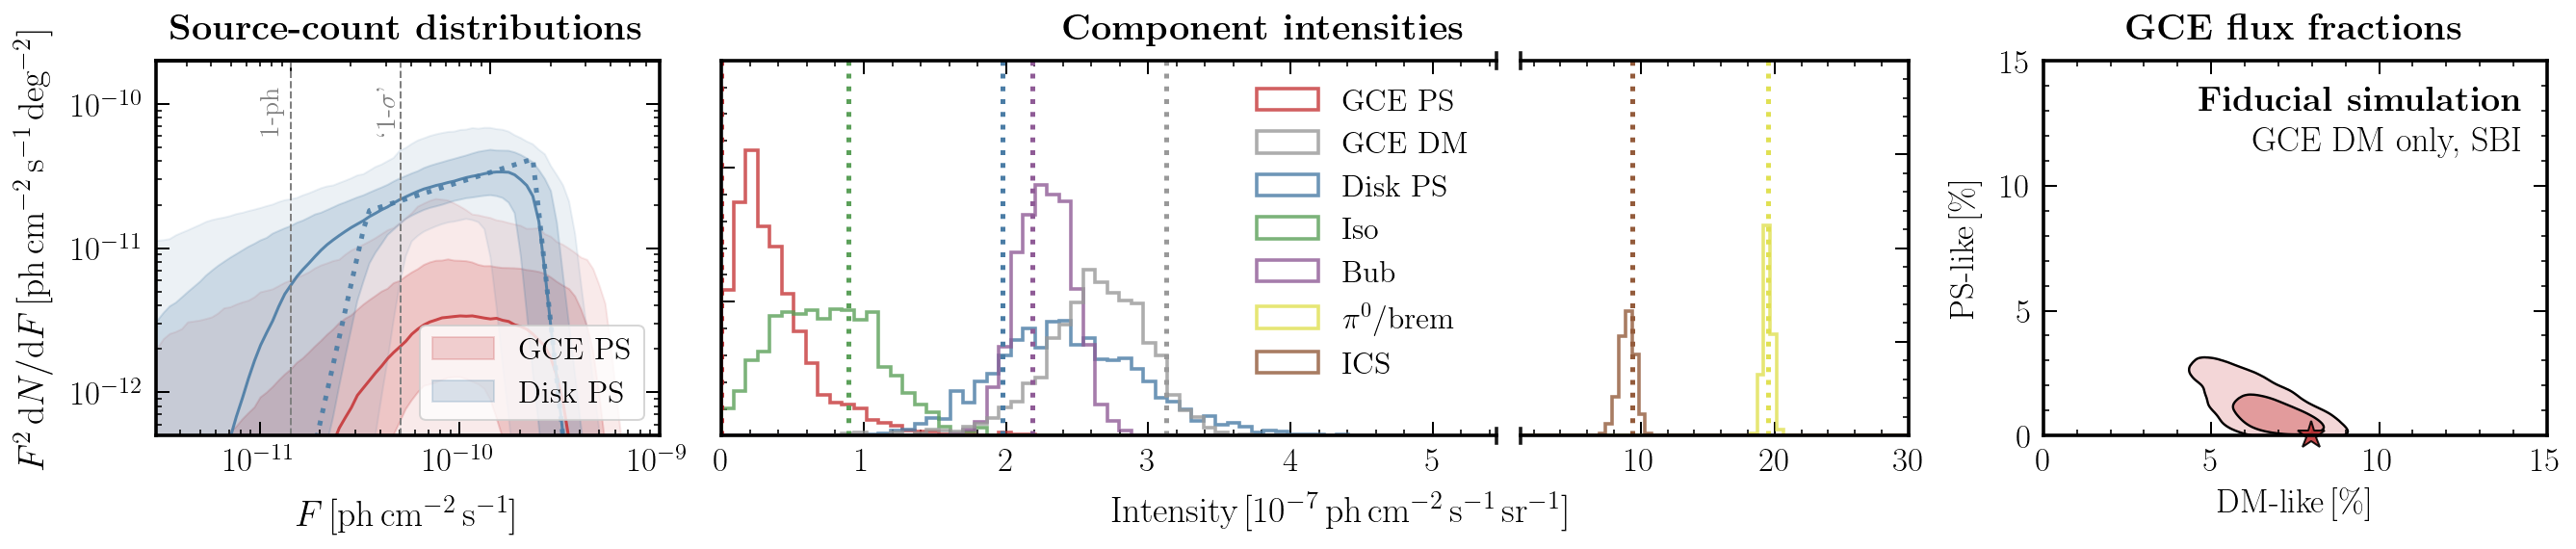

<Figure size 432x324 with 0 Axes>

In [290]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_DM_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, 
          roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_agg.pdf", sub1=r"\bf{Fiducial simulation}", sub2="GCE DM only, SBI", combined_posterior=True, thin_factor=1 / (n_test / 2.)) 

### Mismodeling, Modulation

In [270]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk_thk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 21.13398668 100.91292635 463.71482598]
[0.05115051 0.12930919 0.25110051]
[0.00846025 0.03042428 0.0915246 ]
5.048555292605072e-11 12.508453938130646 70054284171.79971
Removed no burn in
$9.1^{+0.3}_{-0.7}$ & $8.2^{+2.5}_{-4.6}$ & $3.5^{+0.5}_{-1.5}$ & $10.2^{+0.5}_{-1.6}$ & $1.3^{+0.2}_{-0.3}$


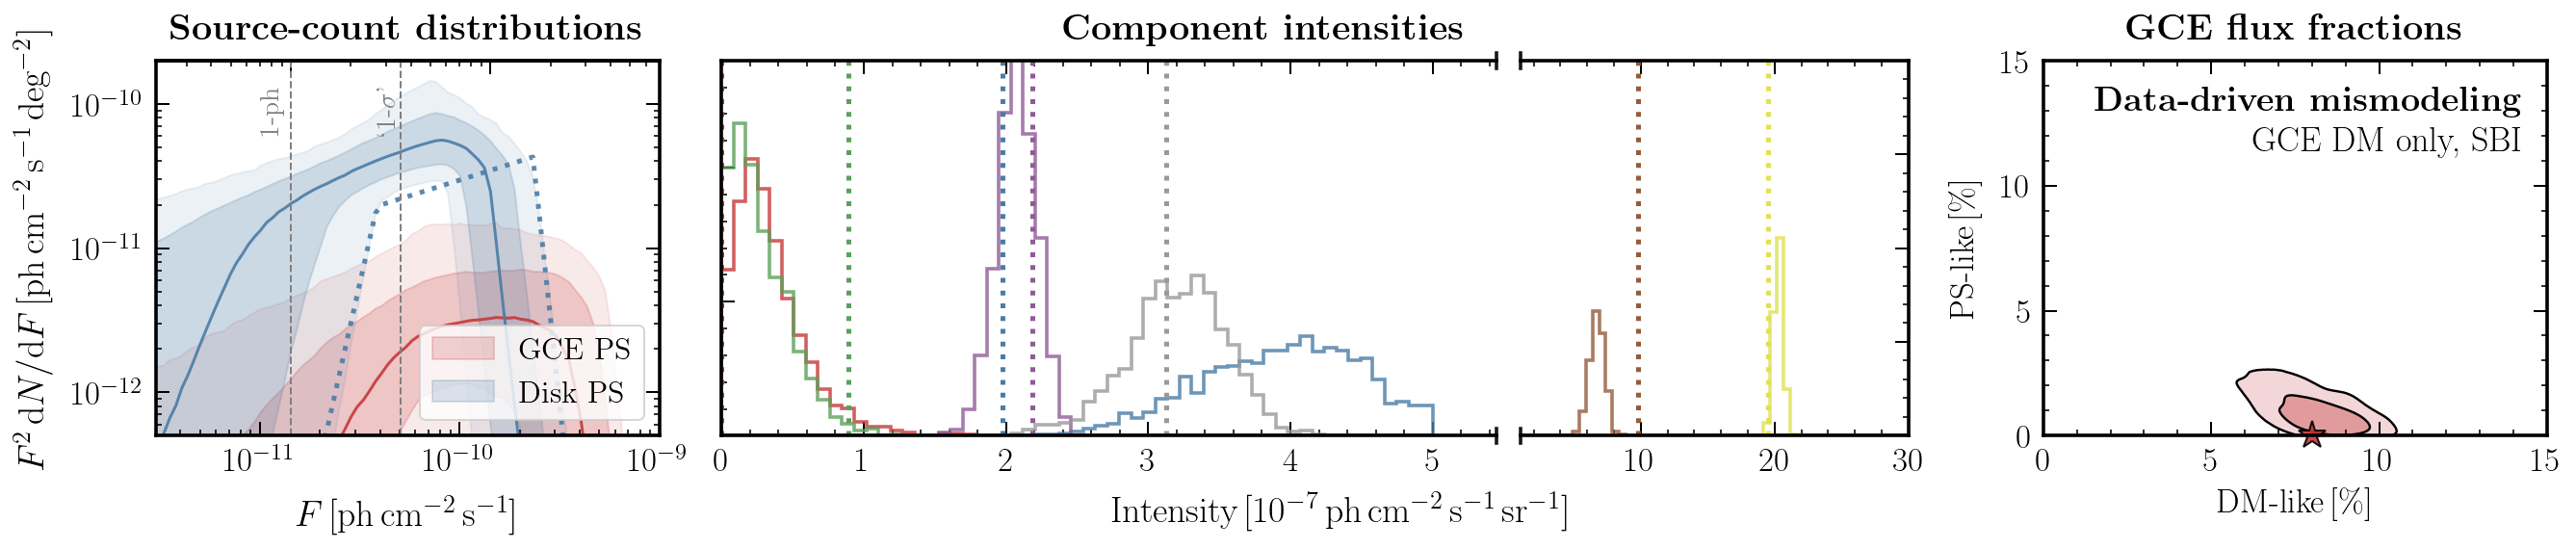

<Figure size 432x324 with 0 Axes>

In [279]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_only_mismo.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_only_mismo.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_DM_only_mismo.npy")[:n_test]

thetas[:, 0] += .4

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, 
          roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_mismo.pdf", sub1=r"\bf{Data-driven mismodeling}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / (n_test / 2.), legend_fontsize=14, show_legend=False) 

In [280]:
# data_map = ring2nest(np.load("../data/samples/x_ModelO_PS_only_mismo.npy")[:3, 0, :], roi_sim_ring)
# aux = np.load("../data/samples/x_aux_ModelO_PS_only_mismo.npy")[:3]
# thetas = np.load("../data/samples/theta_ModelO_PS_only_mismo.npy")[:3]

# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(prior, density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 4), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_ps_mismo.pdf", sub1="Data-driven mismodeling, GCE PS only", sub2="Simulation-based inference", combined_posterior=True, thin_factor=1 / 3) 

## Asymmetric DM

In [281]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[  72.05274006  444.15305761 2002.81626269]
[0.10488181 0.28884745 0.58391304]
[0.02616817 0.11808139 0.35920934]
5.1401170737710426e-11 12.966280756454449 70054284171.79971
Removed no burn in
$10.2^{+0.2}_{-0.6}$ & $15.9^{+5.0}_{-9.6}$ & $1.7^{+0.6}_{-0.7}$ & $3.4^{+0.3}_{-1.0}$ & $2.8^{+0.3}_{-0.8}$


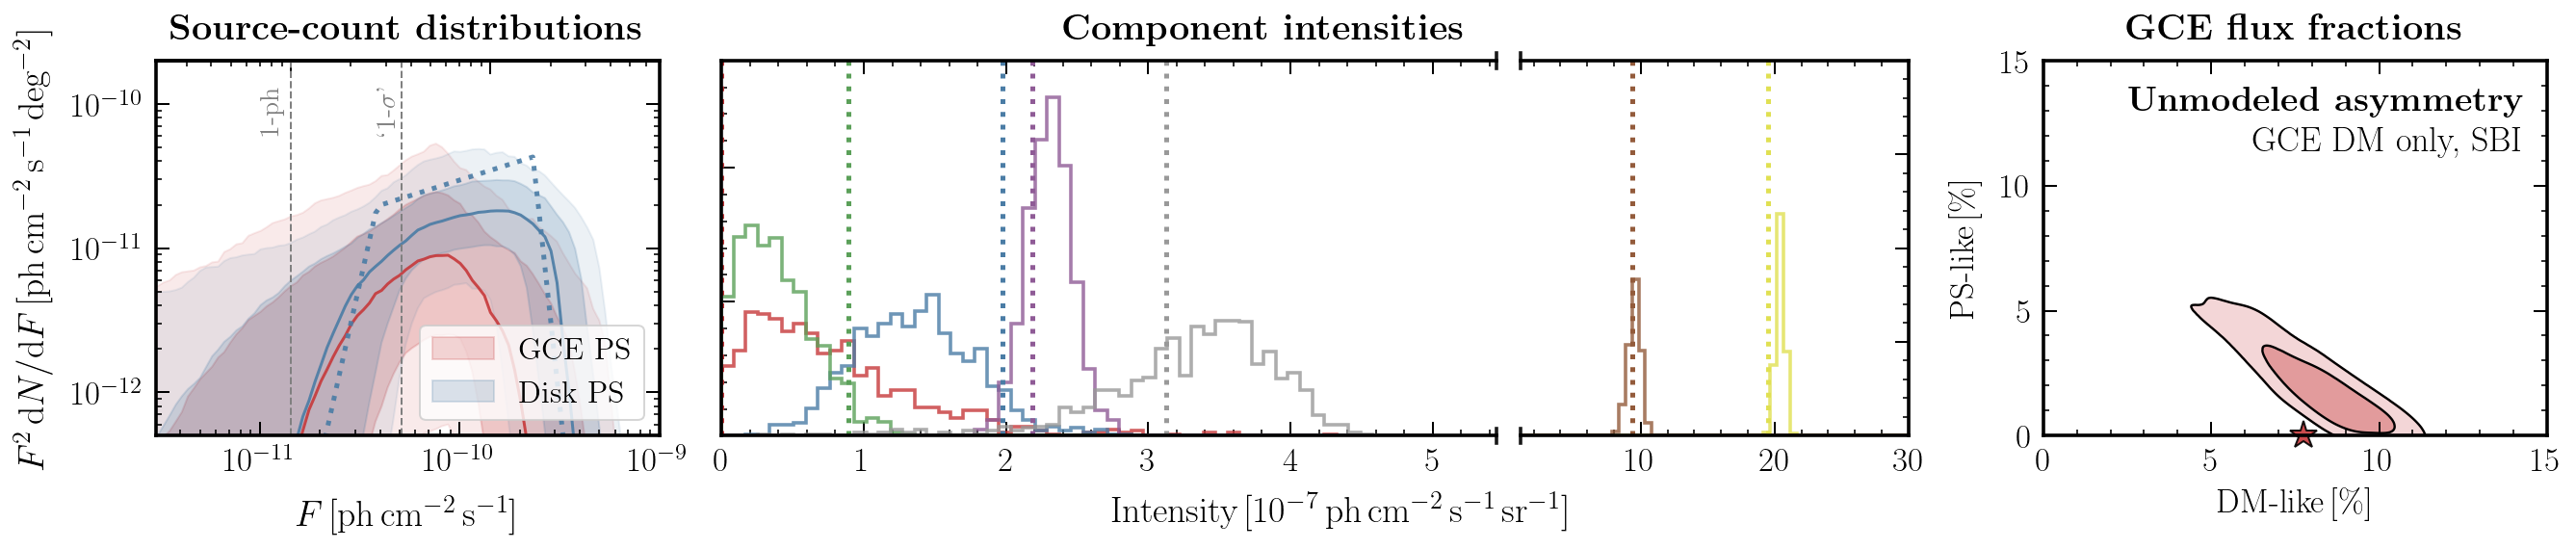

<Figure size 432x324 with 0 Axes>

In [282]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_DM_asym.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_DM_asym.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_DM_asym.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

theta_test_avg = 1.4 * torch.ones(theta_test.shape[0], theta_test.shape[1] - 1)
theta_test_avg[:, 1:] = torch.Tensor(theta_test[:, 2:])
theta_test_avg = theta_test_avg.detach().numpy()

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test_avg, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_dm_asym.pdf", sub1=r"\bf{Unmodeled asymmetry}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / (n_test), legend_fontsize=14, show_legend=False) 

## Model A

In [283]:
# n_test = 15

In [277]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 19.30169793 115.91787799 619.28529165]
[0.03490413 0.10856536 0.22992228]
[0.0071476  0.03126983 0.11381179]
5.107894044832306e-11 12.804220937756714 70054284171.79971
Removed no burn in
$8.9^{+0.3}_{-0.6}$ & $6.8^{+2.1}_{-4.4}$ & $2.5^{+0.7}_{-1.3}$ & $4.6^{+0.4}_{-0.8}$ & $2.9^{+0.2}_{-0.6}$


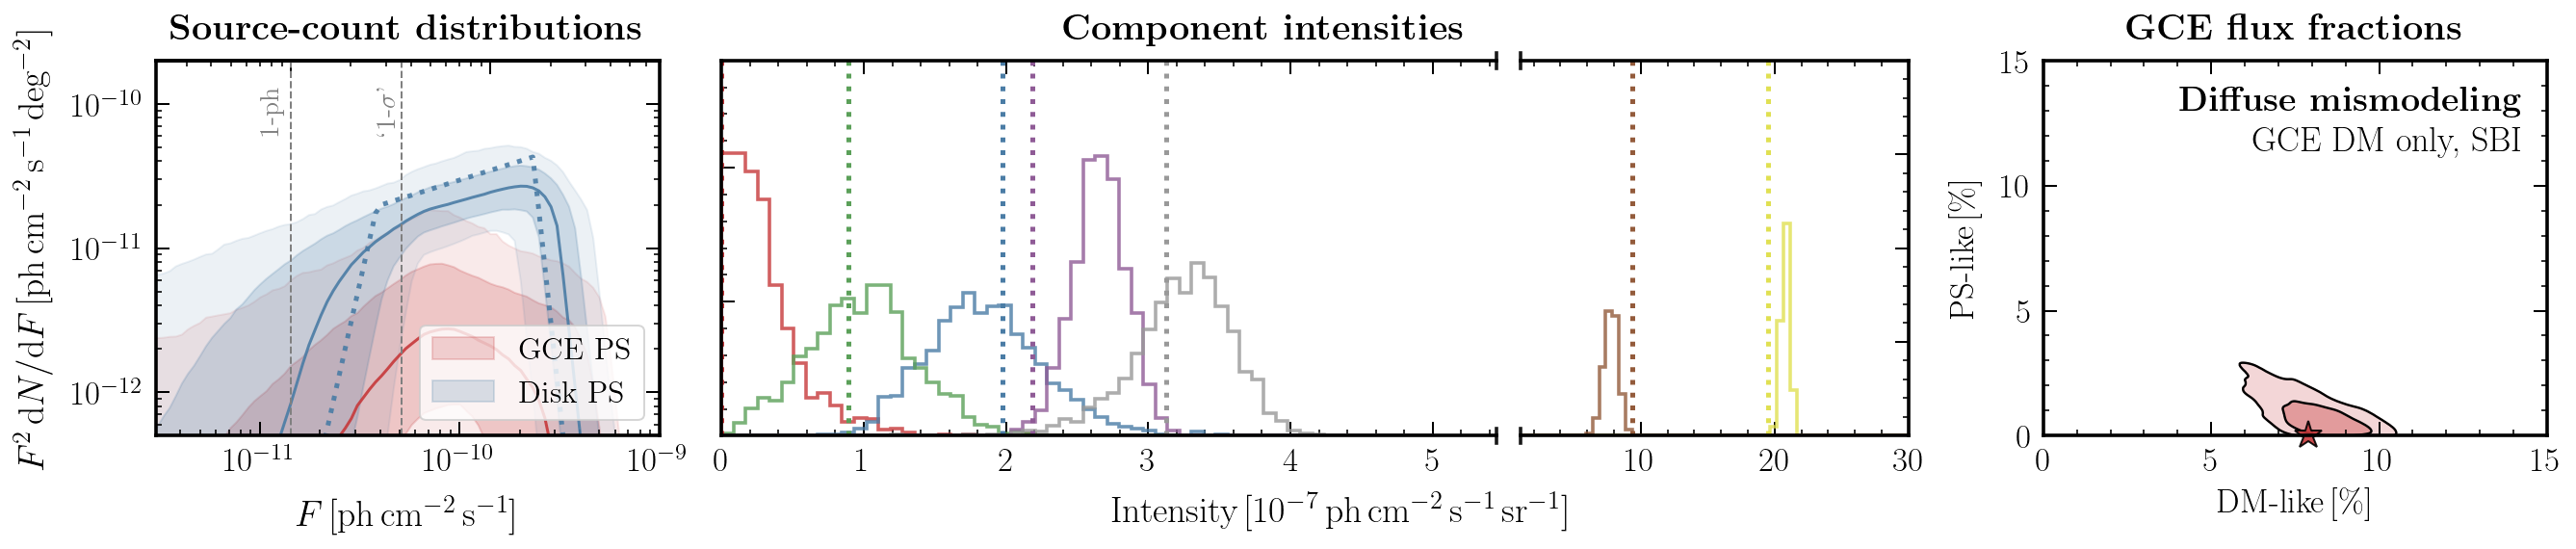

<Figure size 432x324 with 0 Axes>

In [284]:
data_map = ring2nest(np.load("../data/samples/x_ModelA_DM_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelA_DM_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelA_DM_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm,\
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, 
          save_filename="../paper/plots/sim_sbi_modelA_dm.pdf", sub1=r"\bf{Diffuse mismodeling}", sub2="GCE DM only, SBI", 
          combined_posterior=True, thin_factor=1 / (n_test / 2), legend_fontsize=14, show_legend=False) 

In [285]:
# data_map = ring2nest(np.load("../data/samples/x_ModelA_PS_only.npy")[:5, 0, :], roi_sim_ring)
# aux = np.load("../data/samples/x_aux_ModelA_PS_only.npy")[:5]
# thetas = np.load("../data/samples/theta_ModelA_PS_only.npy")[:5]

# x_presimulated = torch.Tensor(data_map).unsqueeze(1)
# x_aux_presimulated = torch.Tensor(aux)
# theta_presimulated = (thetas)

# inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
# posterior = inference_inst.build_posterior(prior, density_estimator)

# x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
# theta_test = theta_presimulated

# make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 4), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_modelA_ps.pdf", sub1="Simulation, Diffuse mismodeling", sub2="Simulation-based inference", combined_posterior=True, thin_factor=1 / 5) 

## Thick disk

In [286]:
temps_poiss_sim = hp.reorder(([temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]), r2n=True)
temps_ps_sim = hp.reorder(([temp_gce / rescale, temp_dsk_thk / rescale]), r2n=True)

temps_dict = {'fermi_exp':fermi_exp,
 'temps_ps':temps_ps,
 'temps_ps_sim':temps_ps_sim,
 'ps_labels':ps_labels,
 'temps_poiss':temps_poiss,
 'temps_poiss_sim':temps_poiss_sim,
 'poiss_labels':poiss_labels}

In [287]:
# n_test = 5

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[  69.0973467   286.99047389 1299.27599376]
[0.15641794 0.32132997 0.54826054]
[0.02838382 0.09068892 0.23660886]
5.0798922235543815e-11 12.664218530209814 70054284171.79971
Removed no burn in
$8.9^{+0.2}_{-0.6}$ & $20.4^{+4.5}_{-9.8}$ & $2.5^{+0.4}_{-1.0}$ & $3.0^{+0.3}_{-0.8}$ & $3.1^{+0.3}_{-0.6}$


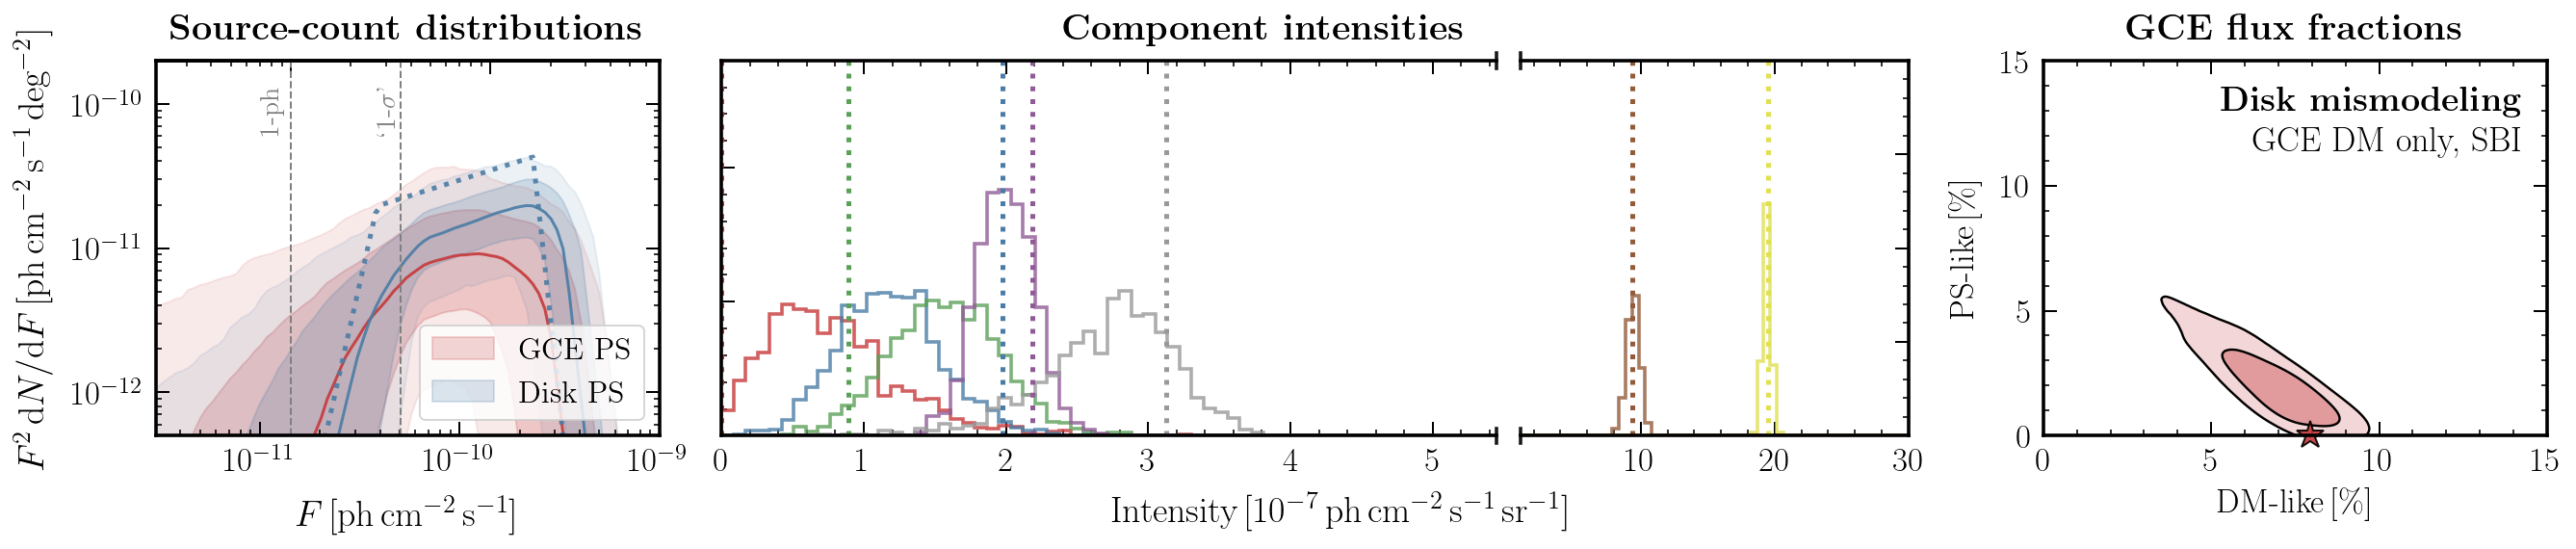

<Figure size 432x324 with 0 Axes>

In [288]:
data_map = ring2nest(np.load("../data/samples/x_ModelO_thick_disk_DM_only.npy")[:n_test, 0, :], roi_sim_ring)
aux = np.load("../data/samples/x_aux_ModelO_thick_disk_DM_only.npy")[:n_test]
thetas = np.load("../data/samples/theta_ModelO_thick_disk_DM_only.npy")[:n_test]

x_presimulated = torch.Tensor(data_map).unsqueeze(1)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = (thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(prior, density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_sim=roi_sim, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, 
          figsize=(24 / 1.3, 5 / 1.3), n_samples=n_samples, temps_dict=temps_dict, save_filename="../paper/plots/sim_sbi_thick_disk_mm_dm.pdf", 
          sub1=r"\bf{Disk mismodeling}", sub2="GCE DM only, SBI", combined_posterior=True, thin_factor=1 / (n_test / 2), legend_fontsize=14, show_legend=False) 

In [299]:
np.mean(fermi_exp[~roi_normalize]) / np.mean(fermi_exp)

1.0622809021169848